In [9]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from ionoptics import geometry as geo
from ionoptics import beamline as bl
from ionoptics import bmad

In [10]:
# beamsize
##JULIC
### 1 sigma x = 6 mm
### 1 sigma y = 9 mm
### brho = 0.98 Tm

##HBS LINAC
### diameter ~ 10 mm (6 sigma)
### 1 sigma = 1.5 mm
### brho = 1.23 Tm

sigma_x = 1.5e-3
brho = 1.23

## quadrupole position evaluation

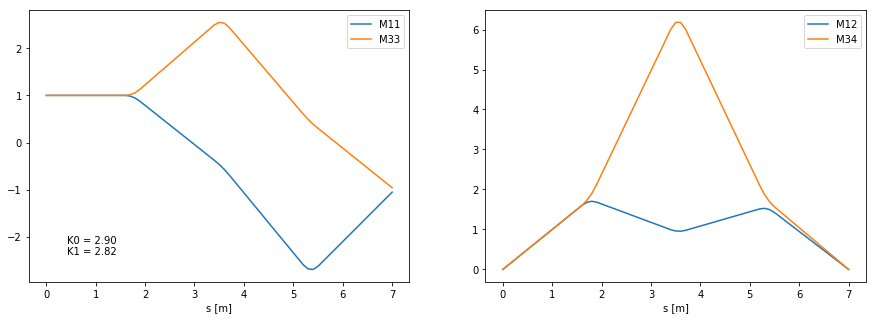

total length:  7.1


In [11]:
l = 1.6 # from object to 1st q
L = 0.3 # q thickness
d = 1.5 # dist. betw. q's

k0,k1 = bl.opt_trip(l,L,d,[2,3],config='FDF')

lengths = [l,L,d,L,d,L,l]
elements = [bl.drift,partial(bl.qf, k=k0),bl.drift,partial(bl.qdf, k=k1),bl.drift,partial(bl.qf, k=k0),bl.drift]

axes = bl.plot_M_vs_s(elements,lengths,figsize = (15,5))

axes[0].text(0.1,0.1,'K0 = {:.2f}\nK1 = {:.2f}'.format(k0,k1),transform=axes[0].transAxes)

#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'QT_eval-1Kicker-{}_{}_{}'.format(l,d,L)
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

print('total length: ', round(2*l+2*d+3*L,2))

### bmad cross check

xmax @  start: 0.009911337779773188
xmax @  end: 0.010971059557402178
ymax @  start: 0.016133803132811955
ymax @  end: 0.01641663180329567


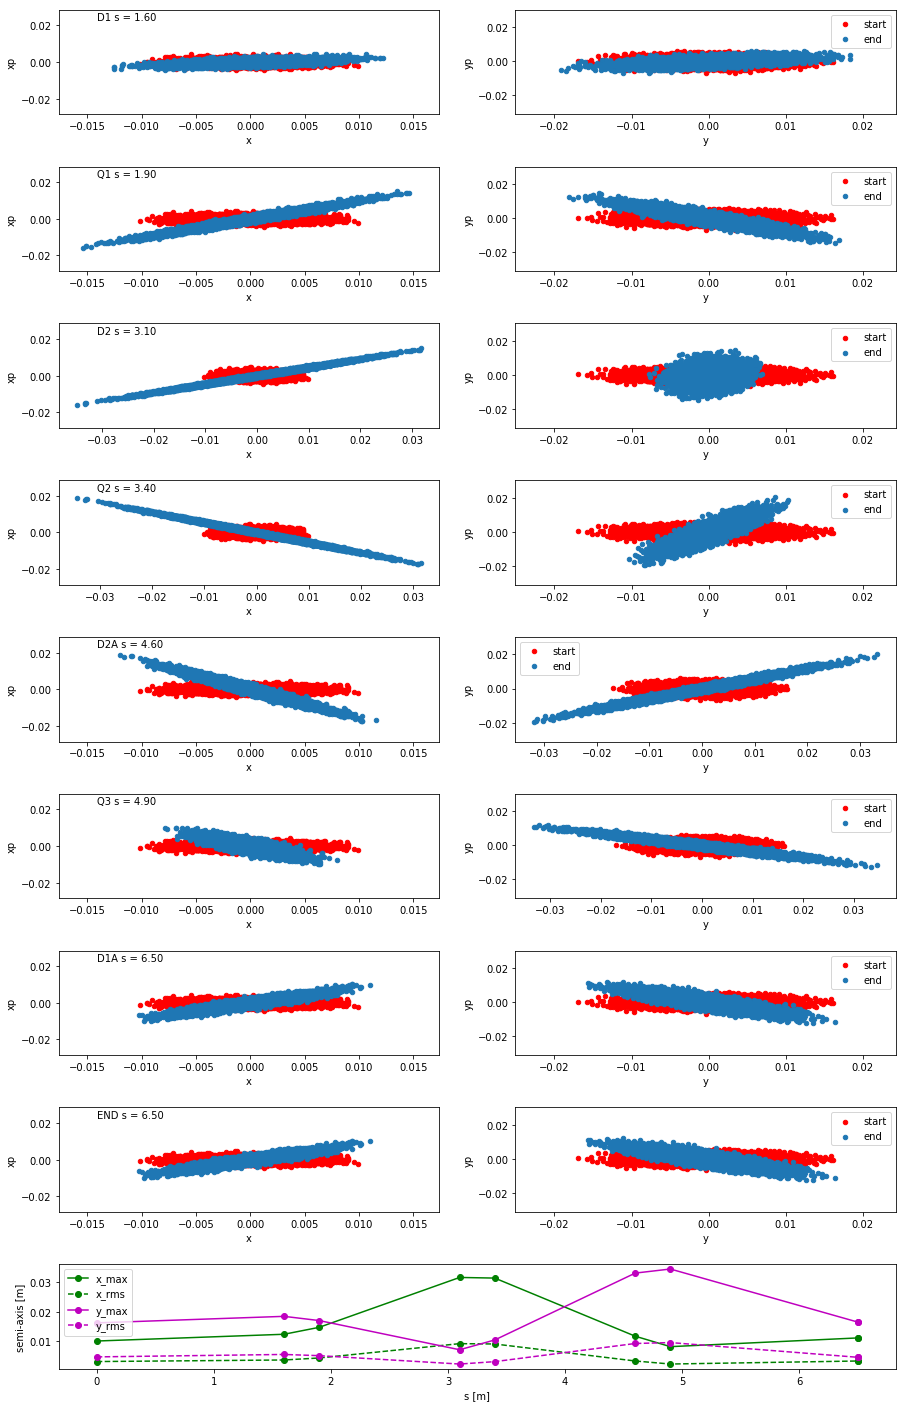

In [12]:
df = bmad.txt_to_df('../../Bmad/Playground/production/bin/','tracking_ele.txt')
bmad.plot_phase_space(df,figsize=(15,25))

#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'pure_tr_FDF-{}_{}_{}_sigmax{}'.format(l,d,L,sigma_x)
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

## kick-septum angle evaluation - 1 kicker setup

In [13]:
## beam parameters
Thet_init = 0

## distances
l_object = 0.2 # 1st q to kicker
l_kick = 1
l_sept = 1

lkq = d-l_kick-l_object
l_max = d + L + lkq # d: from q to q
#l_max = 3 # manually set / w/o qs
## vertical distances
x_init = 0

# at septum
septum = 5e-3
x_sept = 4*sigma_x+septum
# at max prop
x_at_max_prop = 0.5
x_add = x_at_max_prop-x_sept

sept_type = 'DC'

## iteration

start_kick = 0.001 # smallest kick-angle
step_kick = 0.001 # step size kick-angle

list_perm = np.linspace(0,1,1001) # range of septum angles

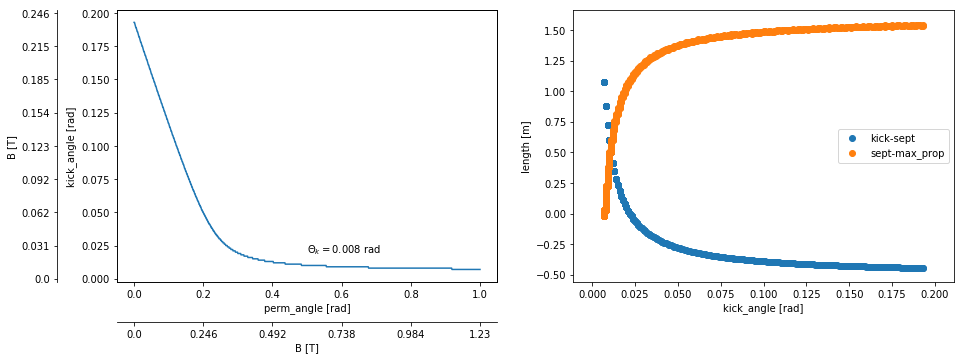

2.1


In [14]:
ax,data= geo.plot_comb_kick_sept(x_sept,
                                 x_add,
                                 x_init,
                                 Thet_init,
                                 l_kick,
                                 l_sept,
                                 sept_type,
                                 start_kick,
                                 step_kick,
                                 list_perm,
                                 l_max,
                                 brho=brho,
                                 figsize = (15,5)
                                )


#PATH_TO_DATA = '../../Multiplexer/Plots/'
#FILENAME = 'ang_eval-1Kicker-{}_{}_{}_simgax{}'.format(l_max,x_at_max_prop,sept_type,sigma_x)
#plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900, bbox_inches="tight")

plt.show()
print(l_max)

In [15]:
kick_d = data[0][0.8]

dks = [d[1] for d in data[1] if d[0] == kick_d]
dks_av = sum(dks)/len(dks)
# kicker-septum


dsf = [d[1] for d in data[2] if d[0] == kick_d]
dsf_av = sum(dsf)/len(dsf)
# septum - final

(kick_d,dks_av,dsf_av,dks_av+dsf_av,l_max-l_sept)

(0.008, 0.8750093334030262, 0.11770895412602514, 0.9927182875290513, 1.1)

## reduced kicker strength by quadrupole

In [16]:
kick_d*dks_av+l_kick*kick_d/2

0.01100007466722421

In [17]:
kick_d*lkq+l_kick*kick_d/2

0.0063999999999999994

In [18]:
reduced = kick_d - 0.7e-3

if (dks_av-lkq-L)>=0:
    total_defl,new_angle = geo.quad_defl(k1,0.3,reduced,l_kick,lkq,dks_av-lkq-L)
    if total_defl >= (kick_d*dks_av+l_kick*kick_d/2):
        print('kicker-quad:', lkq)
        print('quad-septum:', dks_av-lkq-L)
        print(total_defl)
    print(new_angle-kick_d)
else:
    print('not working!:', dks_av-lkq-L)

kicker-quad: 0.3
quad-septum: 0.2750093334030262
0.0110418498105819
0.004239377824790284


## electric deflection

In [19]:
def E_field(Theta,l,Brho,beta):
    
    E = Theta*beta*3e8*Brho/l
    
    return E/1e6

In [20]:
E_field(reduced,1,brho,0.36)

0.969732

In [21]:
#TODO adapt speed of particles for different brho for electric field calculation. 
# find a prototype setup with exb kicker with JULIC beam size

-2.6945332932749166
1.7042716040354198
2.550800682937926
6.178984894153813


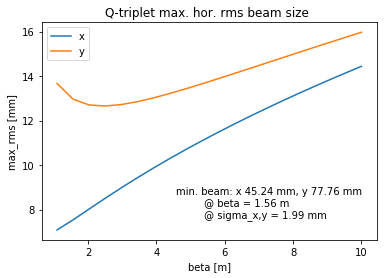

45.244628678202716
77.75937138973688
1.562370493162039
1.9920896196284894
75.9361877590666


In [22]:
eps_LINAC = 2.54 # mm mrad
dia_LINAC = 10 # mm (6 sigma)

beta_init = (dia_LINAC/6)**2/eps_LINAC # m

beta = np.linspace(beta_init,10, 20) # m

sigma_X = np.sqrt(eps_LINAC*beta)
sigma_Xp = np.sqrt(eps_LINAC/beta)

sigma_Y = np.sqrt(eps_LINAC*beta)
sigma_Yp = np.sqrt(eps_LINAC/beta)

Ms = bl.Mplot(elements,lengths)

max_rms_x = abs(max(Ms[1][0], key = abs))*sigma_X+abs(max(Ms[1][1], key = abs))*sigma_Xp
max_rms_y = abs(max(Ms[2][0], key = abs))*sigma_Y+abs(max(Ms[2][1], key = abs))*sigma_Yp

squares = np.sqrt(max_rms_x**2+max_rms_y**2)

print(max(Ms[1][0], key = abs))
print(max(Ms[1][1], key = abs))

print(max(Ms[2][0], key = abs))
print(max(Ms[2][1], key = abs))

np.asarray(Ms[2][0]).argmin()

plt.plot(beta,max_rms_x)
plt.plot(beta,max_rms_y)
plt.legend(['x','y'])

plt.xlabel('beta [m]')
plt.ylabel('max_rms [mm]')
plt.text(0.40,0.1,
         '''min. beam: x {:.2f} mm, y {:.2f} mm  
         @ beta = {:.2f} m 
         @ sigma_x,y = {:.2f} mm'''.format(max_rms_x[squares.argmin()]*6,
                                         max_rms_y[squares.argmin()]*6,
                                         beta[squares.argmin()],
                                         sigma_X[squares.argmin()]),
         transform=plt.gca().transAxes)

plt.title('Q-triplet max. hor. rms beam size ')

PATH_TO_DATA = '../../Multiplexer/Plots/'
FILENAME = 'Twiss_Linac_QT_FDF_eval-{:.2f}'.format(eps_LINAC)
plt.savefig(PATH_TO_DATA + FILENAME, format = 'png', dpi=900)

plt.show()

squares = np.sqrt(max_rms_x**2+max_rms_y**2)


print(max_rms_x[squares.argmin()]*6)
print(max_rms_y[squares.argmin()]*6)
print(beta[squares.argmin()])
print(sigma_X[squares.argmin()])

print(max_rms_y[3]*6)